In [3]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit

In [4]:
# RUN="14180"
# RUN="13850"
# RUN="13859"
RUN="14498"

# Argon Runs
if (RUN == "14180" or RUN == "13850"):
    cathode_cut = 797
    nbins = 10
    bound_params = 6.25e5, 0.5e6, 250 
    q0_low = 2.5e3
    low_charge_lim = 1e7

elif (RUN == "13859"):
    cathode_cut = 755
    nbins = 10
    bound_params = 6.25e5, 0.6e6, 1500 
    q0_low = 2.5e3
    low_charge_lim = 1e7

# Xenon Runs
elif (RUN == "14498"):
    cathode_cut = 1275
    nbins = 10
    bound_params = 6.25e5, 0.5e6, 250 
    q0_low = 2.5e3
    low_charge_lim = 1e7

print("The run is:", RUN)

The run is: 14498


In [5]:
file = f"../data/analysis/Run_{RUN}_Filtered.h5"

# Load the data
data_properties = pd.read_hdf(file, "data_properties")

# Convert 'event' columns to integers
data_properties['event'] = data_properties['event'].astype(int)

# Get event_ids where 'x' or 'y' has NaN values
nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['cath_time'].isna()]['event'].values)

# Filter out rows in data and data_properties based on the 'event' column
data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]

# data_properties["S2_area"] = data_properties["S2_areafit"]

# Check if there are still NaN values
print(data_properties.isna().sum())

display(data_properties)
print(len(data_properties.event.unique()))

event           0
S2_area         0
S2_areafit      0
S2_time         0
cath_area       0
cath_time       0
cath_std       51
ts_raw          0
deltaT          0
sigma           0
S2_amp          0
x               0
y               0
grass_peaks     0
nS1             0
ts              0
dtype: int64


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts
0,17351,7.075970e+05,7.317886e+05,1602.887048,36.162972,2524.901667,16.933063,1.730124e+09,-999.000,2.366650,1.206814e+05,381.175,-201.525,0,0,2024-10-28 08:55:20.951
1,17358,9.804880e+06,9.791496e+06,1612.569223,370.746339,2531.626389,15.224785,1.730124e+09,-999.000,5.401290,7.477605e+05,-220.275,-402.175,0,2,2024-10-28 08:55:21.128
2,17365,1.754540e+07,1.737550e+07,1611.000349,1362.803468,2522.144444,13.463473,1.730124e+09,-999.000,3.976476,1.763653e+06,73.175,-217.575,1,2,2024-10-28 08:55:21.298
3,17372,2.585656e+06,6.666588e+06,1605.670016,771.020815,2523.882692,12.523046,1.730124e+09,-999.000,13.621407,1.331079e+05,196.575,-124.275,3,3,2024-10-28 08:55:21.540
4,17379,2.475571e+06,2.536587e+06,1606.024741,185.614031,2527.791667,15.768368,1.730124e+09,1322.300,6.234440,1.762819e+05,-65.775,461.625,0,1,2024-10-28 08:55:21.826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,19383,1.736928e+07,1.713251e+07,1613.538126,277.157216,2527.172500,16.575570,1.730124e+09,1050.725,5.628345,1.258681e+06,119.825,44.775,2,1,2024-10-28 08:56:34.303
55,19390,1.223586e+07,1.223876e+07,1614.325710,475.245738,2519.226250,16.226891,1.730124e+09,1325.450,6.110655,8.115654e+05,319.975,-78.125,0,1,2024-10-28 08:56:34.604
56,19397,1.834463e+07,2.293836e+07,1604.155293,67.548117,2513.620000,11.334438,1.730124e+09,-999.000,1.925828,4.211172e+06,73.175,122.525,0,0,2024-10-28 08:56:34.848
57,19404,1.769483e+07,1.753842e+07,1614.251998,743.420910,2530.822727,14.010376,1.730124e+09,1088.900,5.641572,1.265778e+06,57.625,-47.525,0,1,2024-10-28 08:56:35.093


15478


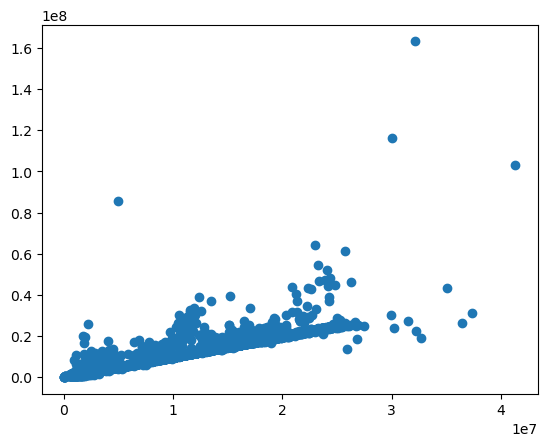

In [6]:
plt.figure()
plt.scatter(data_properties.S2_area, data_properties.S2_areafit)

In [7]:
# Rebin the x and y

# Define bin edges using np.linspace for x and y
x_bins = np.linspace(-500, 500, nbins)  # 10 evenly spaced bins between -500 and 500
y_bins = np.linspace(-500, 500, nbins)

# Bin the x and y columns
data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

# Calculate bin centers
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

print(data_properties['x_bin'].unique())
print(len(data_properties['x_bin'].unique()))

# Assign the bin centers as new columns
data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

# Assign a unique bin ID for each (x_bin, y_bin) pair
data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

display(data_properties)

[7 2 5 6 3 0 4 8 1]
9


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x,y,grass_peaks,nS1,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,17351,7.075970e+05,7.317886e+05,1602.887048,36.162972,2524.901667,16.933063,1.730124e+09,-999.000,2.366650,...,381.175,-201.525,0,0,2024-10-28 08:55:20.951,7,2,333.333333,-222.222222,7_2
1,17358,9.804880e+06,9.791496e+06,1612.569223,370.746339,2531.626389,15.224785,1.730124e+09,-999.000,5.401290,...,-220.275,-402.175,0,2,2024-10-28 08:55:21.128,2,0,-222.222222,-444.444444,2_0
2,17365,1.754540e+07,1.737550e+07,1611.000349,1362.803468,2522.144444,13.463473,1.730124e+09,-999.000,3.976476,...,73.175,-217.575,1,2,2024-10-28 08:55:21.298,5,2,111.111111,-222.222222,5_2
3,17372,2.585656e+06,6.666588e+06,1605.670016,771.020815,2523.882692,12.523046,1.730124e+09,-999.000,13.621407,...,196.575,-124.275,3,3,2024-10-28 08:55:21.540,6,3,222.222222,-111.111111,6_3
4,17379,2.475571e+06,2.536587e+06,1606.024741,185.614031,2527.791667,15.768368,1.730124e+09,1322.300,6.234440,...,-65.775,461.625,0,1,2024-10-28 08:55:21.826,3,8,-111.111111,444.444444,3_8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,19383,1.736928e+07,1.713251e+07,1613.538126,277.157216,2527.172500,16.575570,1.730124e+09,1050.725,5.628345,...,119.825,44.775,2,1,2024-10-28 08:56:34.303,5,4,111.111111,0.000000,5_4
55,19390,1.223586e+07,1.223876e+07,1614.325710,475.245738,2519.226250,16.226891,1.730124e+09,1325.450,6.110655,...,319.975,-78.125,0,1,2024-10-28 08:56:34.604,7,3,333.333333,-111.111111,7_3
56,19397,1.834463e+07,2.293836e+07,1604.155293,67.548117,2513.620000,11.334438,1.730124e+09,-999.000,1.925828,...,73.175,122.525,0,0,2024-10-28 08:56:34.848,5,5,111.111111,111.111111,5_5
57,19404,1.769483e+07,1.753842e+07,1614.251998,743.420910,2530.822727,14.010376,1.730124e+09,1088.900,5.641572,...,57.625,-47.525,0,1,2024-10-28 08:56:35.093,5,4,111.111111,0.000000,5_4


In [8]:
print(len(nan_event_ids))
data_properties.describe()
tc=25e-3

0


Text(0.5, 1.0, 'RUN 14498')

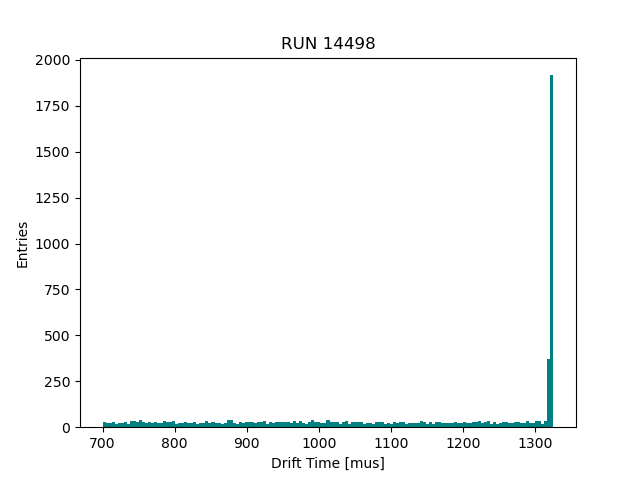

In [12]:
%matplotlib widget
plt.figure()

plt.hist(data_properties.deltaT, bins = np.linspace(700, cathode_cut+50, 150), color = "Teal");
plt.xlabel("Drift Time [mus]")
plt.ylabel("Entries")
plt.title(f"RUN {RUN}")


False


Text(0, 0.5, 'Y [mm]')

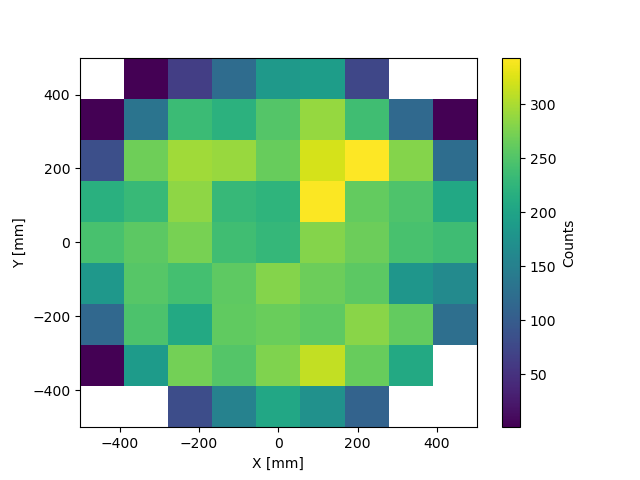

In [13]:
%matplotlib widget
fig, ax = plt.subplots()
has_nan = data_properties['x'].isna().any()
print(has_nan)

hist, xedges, yedges = np.histogram2d(data_properties.x, data_properties.y, bins=[np.linspace(-500,500,nbins),np.linspace(-500,500,nbins)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



In [14]:
data_properties_active = data_properties[ (data_properties.deltaT > 0) & (data_properties.deltaT < cathode_cut)]

data_properties_active = data_properties_active[data_properties_active["S2_area"] < 3e7]

5_4 17.932251634297057 42.25128773395911


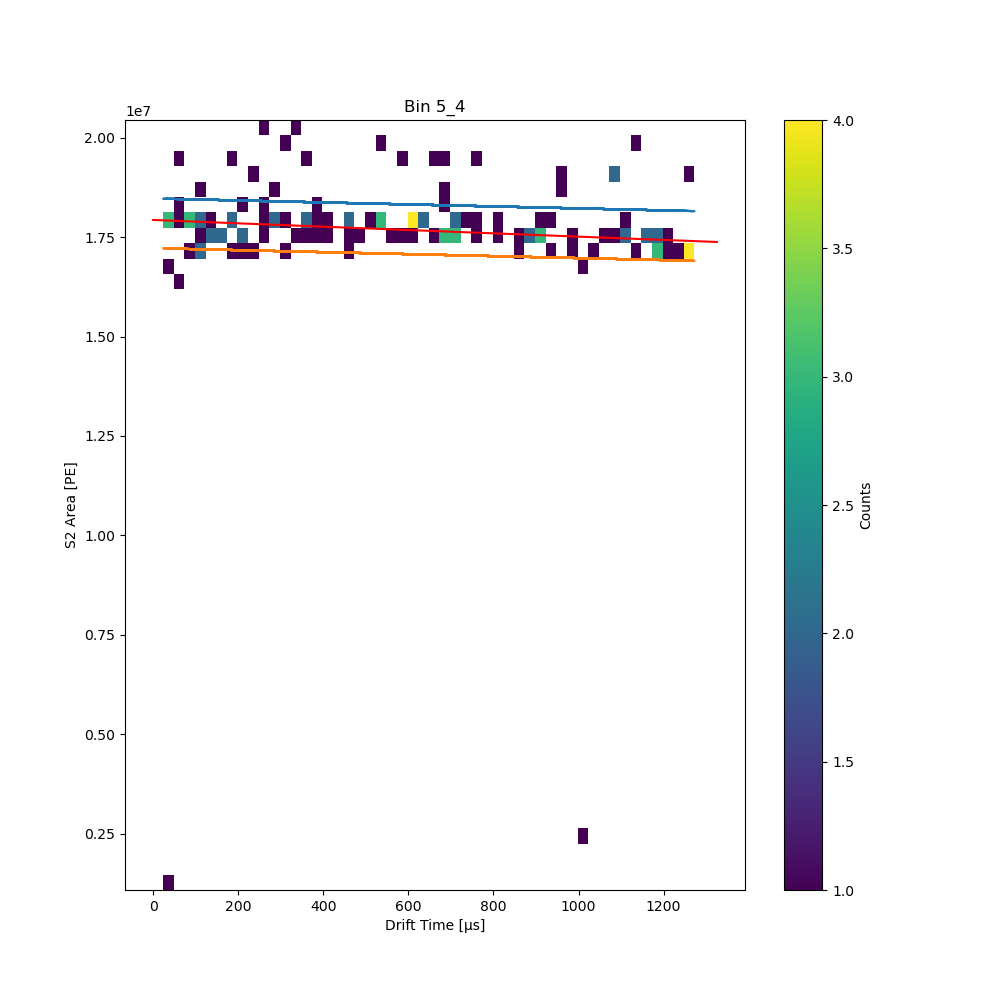

In [15]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    if (tau == 0):
        return np.ones(len(t))
    else:
        return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts

    lower_bound = max_bin_value-bound_params[0] + bound_params[1]
    upper_bound = max_bin_value+bound_params[0] + bound_params[1]

    # print("Max bin value is:", max_bin_value)
    # print("Lower/upper bound is:", lower_bound, upper_bound)

    df_bin = df_bin[ (df_bin.S2_area > -bound_params[2]*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -bound_params[2]*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 15):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)

    t = np.linspace(0,cathode_cut+50,300)
    plt.plot(df_bin['deltaT'], -bound_params[2]*df_bin.deltaT+upper_bound) # if you want to plot the bands plot this. 
    plt.plot(df_bin['deltaT'], -bound_params[2]*df_bin.deltaT+lower_bound)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, bounds = ([q0_low, 1e3], [2.3e7, 150e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    print(binid, q_fit/1e6, tau_fit/1e3 )

    return q_fit, tau_fit

fig, ax = plt.subplots(1, 1, figsize=(nbins, nbins))

# Filter data based on the current bin_id
bin_ = "5_4"
df_bin = data_properties_active[data_properties_active.bin_id == bin_] # 4_5, 

# Create 2D histogram
hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=50)

# Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# Custom colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# Plot with pcolormesh
pcm = ax.pcolormesh(x_edges, y_edges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

# Set labels
ax.set_xlabel("Drift Time [μs]")
ax.set_ylabel("S2 Area [PE]")
ax.set_title(f"Bin {bin_}")
# ax.set_ylim(2.5e8,4.5e8)

# # Generate fitted curve
t_fit = np.linspace(0, cathode_cut+50, 100)

q_fit, tau_fit = FitLifetime(data_properties_active, bin_)
hist_fit = exp_decay(t_fit, q_fit, tau_fit)

# # Plotting the fitted exponential decay curve
ax.plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_46290/2790404921.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


4_8 15.123757997738766 61.41902893398215
5_8 15.55862408389476 53.828600682086986
2_7 16.296490484710166 81.25162578974103
3_7 16.969374303705816 78.76106609387315
4_7 16.99262029969281 46.48297480170557
5_7 16.939012939548327 43.077893372409854
6_7 16.12998188597019 50.8284813176896
7_7 14.851983626840154 25.130436692437282
1_6 16.658667218230192 59.42970206502316
2_6 17.41990726650238 129.11643845399215
3_6 17.69136230202159 53.70666670320592
4_6 17.650035715926567 54.58140359694676
5_6 17.558452379970653 67.34729570945917
6_6 17.101095010351727 40.742903547743985
7_6 16.194140304915567 60.14000860396728
0_5 15.10649849165253 58.66804666614827
1_5 16.978105812126945 43.57489610291587
2_5 17.71066824580747 37.816929230875836
3_5 17.74174472387983 42.535174073448324
4_5 18.03102653311708 29.562351267136524
5_5 18.00788046792856 28.279937219925536
6_5 17.530944893933633 47.88337708205001
7_5 16.952025048508716 79.30503034962003
8_5 16.121607844088892 17.206487871892822
0_4 15.9545552534

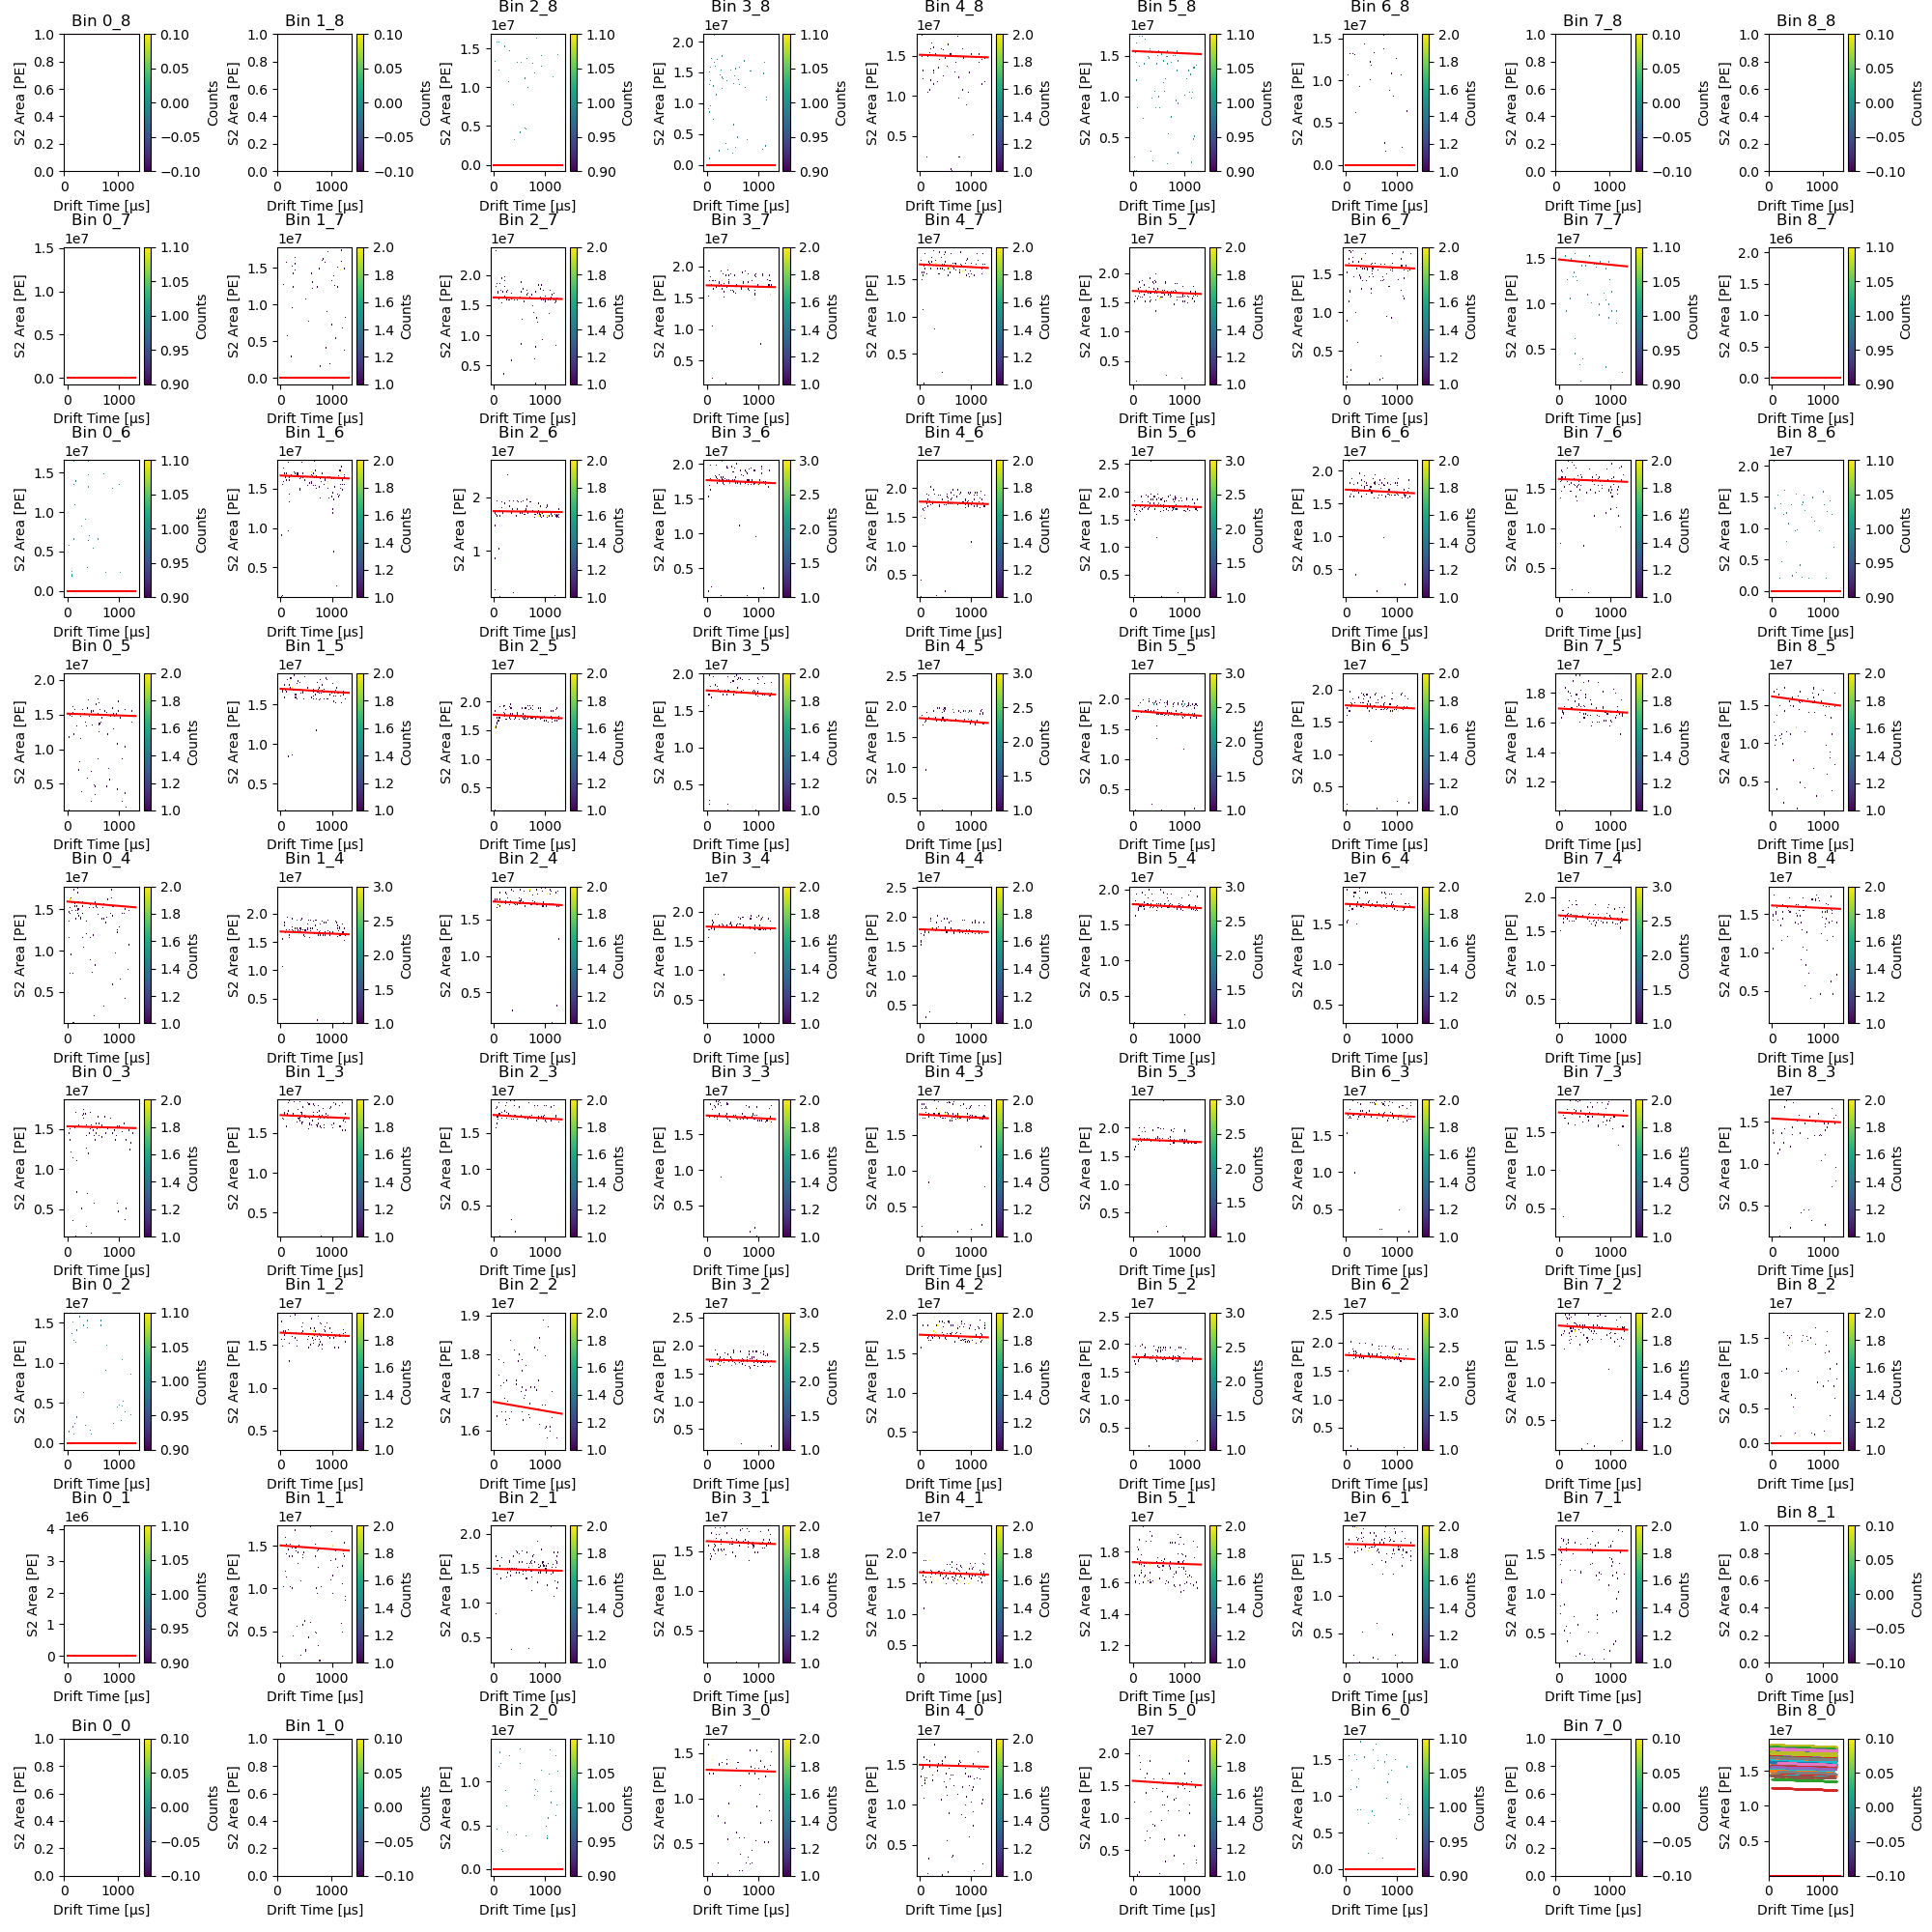

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_46290/2790404921.py:84: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['bin_id', 'lt', 'q0'], dtype='object')]

  lifetime_df.to_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", key='map', mode='w')


In [16]:
# Make a plot of the time vs peak width

data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)
data_properties_active = data_properties_active[data_properties_active.S2_amp > 0]

data_properties['sigma'] = data_properties['sigma'].fillna(0)
data_properties['S2_amp'] = data_properties['S2_amp'].fillna(-1)
data_properties = data_properties[data_properties.S2_amp > 0]


# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("S2 Area [PE]")
    ax.set_title(f"Bin {bin_id}")
    # ax.set_ylim(2.5e8,4.5e8)


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(nbins-1, nbins-1, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        
        plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

        t_fit = np.linspace(0, cathode_cut+50, 100)

        q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
        hist_fit = exp_decay(t_fit, q_fit, tau_fit)

        # # Plotting the fitted exponential decay curve
        axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

        # Create a new DataFrame to append
        new_data = pd.DataFrame({
            "bin_id": [f"{x}_{y}"],
            "lt": [tau_fit],
            "q0": [q_fit]
        })

        lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# lifetime_df.loc[lifetime_df['lt'] > 99e3, 'lt'] = 0

# Save the calibration map
lifetime_df.to_hdf(f"../maps/LifetimeMap_Run_{RUN}.h5", key='map', mode='w')


,bin_id,lt,q0
0,0_8,0,0
1,1_8,0,0
2,2_8,0,0
3,3_8,0,0
4,4_8,61419.028934,15123757.997739
...,...,...,...
76,4_0,80152.39289,14917302.55279
77,5_0,29427.749753,15712508.931077
78,6_0,0,0
79,7_0,0,0


Text(0.5, 1.0, '14498 Q0')

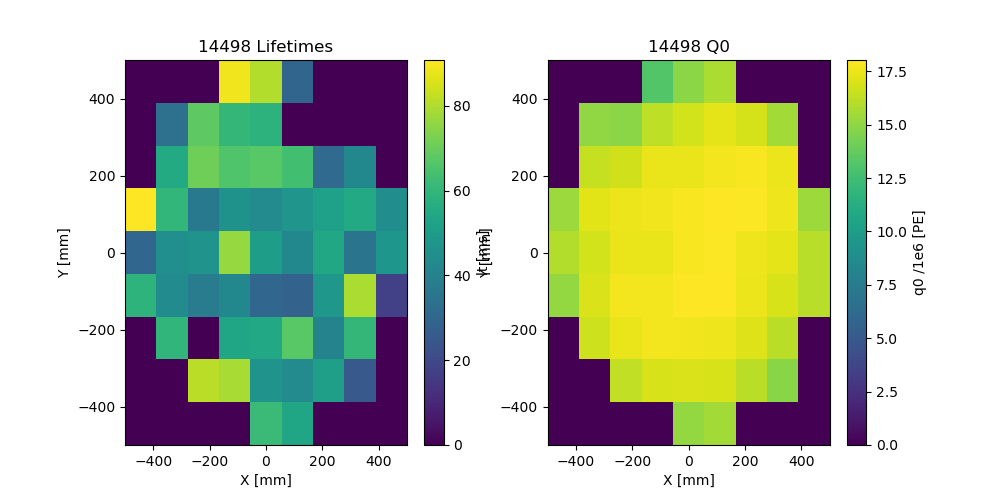

In [17]:
%matplotlib widget

display(lifetime_df)

# Function to extract x and y positions from bin_id
def get_bin_position_from_id(bin_id, x_bin_centers, y_bin_centers):
    try:
        x_bin, y_bin = map(int, bin_id.split('_'))  # Split and convert bin_id to integers
        return x_bin_centers[x_bin], y_bin_centers[y_bin]
    except (ValueError, IndexError) as e:
        return np.nan, np.nan  # Return NaN if there's an issue with the bin_id

# Apply the function to create new columns
lifetime_df_pos= lifetime_df
lifetime_df_pos[['x_center', 'y_center']] = lifetime_df['bin_id'].apply(
    lambda bid: pd.Series(get_bin_position_from_id(bid, x_bin_centers, y_bin_centers))
)


lifetime_df_pos.loc[lifetime_df_pos['lt'] > 100e3, 'lt'] = 0

# Create pivot table to reshape the data for 2D plotting
lt_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='lt')

# Sort the axes (necessary if bin centers are not in order)
lt_pivot = lt_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
lt_pivot = lt_pivot.astype(float).fillna(0) 

# Create pivot table to reshape the data for 2D plotting
q0_pivot = lifetime_df_pos.pivot(index='y_center', columns='x_center', values='q0')

# Sort the axes (necessary if bin centers are not in order)
q0_pivot = q0_pivot.sort_index(ascending=False)  # y-axis usually goes from top to bottom
q0_pivot = q0_pivot.astype(float).fillna(0) 


# Plotting using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the pcolormesh plot
c = axs[0].pcolormesh(x_bins, y_bins, lt_pivot / 1e3, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[0], label='lt [ms]')  # Specify 'ax' to link the color bar to the plot
axs[0].set_xlabel('X [mm]')
axs[0].set_ylabel('Y [mm]')
axs[0].set_title(f'{RUN} Lifetimes')


c = axs[1].pcolormesh(x_bins, y_bins, q0_pivot / 1e6, cmap='viridis', shading='auto')
fig.colorbar(c, ax=axs[1], label='q0 /1e6 [PE]')  # Specify 'ax' to link the color bar to the plot
axs[1].set_xlabel('X [mm]')
axs[1].set_ylabel('Y [mm]')
axs[1].set_title(f'{RUN} Q0')


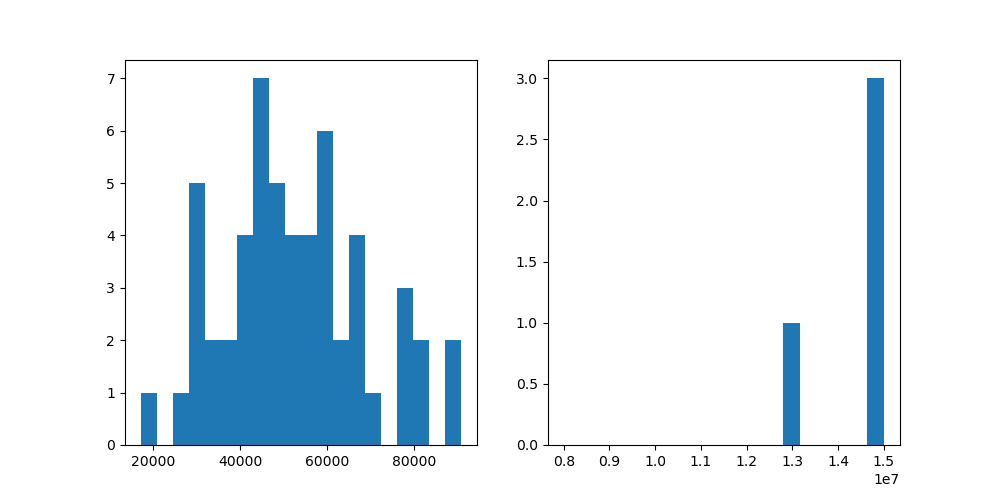

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(lifetime_df[lifetime_df["lt"] > 0]["lt"], bins =20);
axs[1].hist(lifetime_df[lifetime_df["q0"] > 0]["q0"], bins =np.linspace(0.8e7,1.5e7,20));

In [19]:
# Plot the alpha map of

def CorrectLifetime(row, var, q0_max):

    lt = row["lt"]
    time = row["deltaT"]
    q0 = row["q0"]

    if (q0 == 0):
        q_corr = 1
    else:
        q_corr = q0_max/q0


    if (lt == 0):
        return 0
    else:
        return q_corr * row[var] / np.exp(-1*time/lt)

def CorrectLifetimeAvg(row, var, t, mean_lt):

    time = row[t]

    if (mean_lt == 0):
        return 1
    else:
        return row[var] / np.exp(-1*time/mean_lt)



mean_lt = np.mean (lifetime_df[ (lifetime_df["lt"] > 0) & (lifetime_df["lt"] < 100e3)]["lt"])
print("Mean Lifetime is:", mean_lt/1e3, " ms")

data_properties_active_lt = pd.merge(data_properties_active, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_active_lt.q0)
data_properties_active_lt["S2_areaC"] = data_properties_active_lt.apply(lambda row: CorrectLifetime(row, "S2_area", q0_max), axis=1)
data_properties_active_lt["R"] = np.sqrt(data_properties_active_lt["x"]*data_properties_active_lt["x"] + data_properties_active_lt["y"]*data_properties_active_lt["y"])

data_properties_lt = pd.merge(data_properties, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_lt.q0)
data_properties_lt["S2_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetime(row,"S2_area", q0_max), axis=1)
data_properties_lt["R"] = np.sqrt(data_properties_lt["x"]*data_properties_lt["x"] + data_properties_lt["y"]*data_properties_lt["y"])
data_properties_lt["cath_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetimeAvg(row,"cath_area", "deltaT",  mean_lt), axis=1)

nan_event_ids = data_properties_lt[data_properties_lt['R'].isna()]['event'].values
print(nan_event_ids)

display(data_properties_active_lt)


Mean Lifetime is: 52.31716673794604  ms
[]


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R
0,17393,1.810995e+07,1.843112e+07,1606.071545,291.569860,2528.879167,10.918723,1.730124e+09,95.625,2.258617,...,2,-222.222222,-222.222222,2_2,70833.518102,16742187.38516,-222.222222,-222.222222,1.953044e+07,324.152096
1,17421,1.657486e+07,1.637928e+07,1608.437213,170.004434,2519.893750,9.719592,1.730124e+09,248.850,2.882348,...,1,0.000000,-333.333333,4_1,58454.495015,16770680.317425,0.000000,-333.333333,1.789652e+07,311.008185
2,17449,1.796636e+07,1.761426e+07,1614.790905,286.082228,2522.691250,15.393448,1.730124e+09,997.075,5.292488,...,2,-222.222222,-222.222222,2_2,70833.518102,16742187.38516,-222.222222,-222.222222,1.962373e+07,333.659154
3,17463,1.683330e+07,1.678691e+07,1613.715870,776.695955,2521.402273,12.554540,1.730124e+09,991.425,5.647876,...,5,-444.444444,111.111111,0_5,58668.046666,15106498.491653,-444.444444,111.111111,2.043454e+07,408.000069
4,17470,1.607247e+07,1.589250e+07,1611.515783,291.770948,2528.152500,10.502694,1.730124e+09,658.625,4.332339,...,4,444.444444,0.000000,8_4,47868.154817,16126365.646606,444.444444,0.000000,1.821974e+07,399.300077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7957,19355,1.579283e+06,1.603026e+06,1605.083870,1820.452662,2524.653125,13.707454,1.730124e+09,607.500,4.778362,...,6,222.222222,222.222222,6_6,40742.903548,17101095.010352,222.222222,222.222222,1.690176e+06,345.886551
7958,19369,1.757356e+07,1.725162e+07,1611.111311,428.097805,2523.941176,16.199269,1.730124e+09,655.850,4.591757,...,4,111.111111,0.000000,5_4,42251.287734,17932251.634297,111.111111,0.000000,1.794679e+07,105.167872
7959,19376,1.633106e+07,1.685846e+07,1604.901445,122.552331,2517.045000,12.175788,1.730124e+09,67.325,1.689437,...,5,-222.222222,111.111111,2_5,37816.929231,17710668.245807,-222.222222,111.111111,1.665609e+07,276.400970
7960,19383,1.736928e+07,1.713251e+07,1613.538126,277.157216,2527.172500,16.575570,1.730124e+09,1050.725,5.628345,...,4,111.111111,0.000000,5_4,42251.287734,17932251.634297,111.111111,0.000000,1.790472e+07,127.917283


In [20]:
data_properties_active_lt.describe()

,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,nS1,ts,x_bin,y_bin,x_bin_center,y_bin_center,x_center,y_center,S2_areaC,R
count,7962.000000,7.962000e+03,7.962000e+03,7962.000000,7.962000e+03,7962.000000,7930.000000,7.962000e+03,7962.000000,7962.000000,...,7962.0,7962,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7962.000000,7.962000e+03,7962.000000
mean,600460.191786,1.547385e+07,1.556661e+07,1610.355826,4.822694e+03,2525.127493,12.815918,1.730145e+09,636.145566,4.295352,...,1.0,2024-10-28 14:49:17.481981696,4.004396,3.947752,0.488431,-5.805353,0.488431,-5.805353,1.477613e+07,322.797617
min,3.000000,5.906487e+05,6.027295e+05,1599.300000,-4.292104e+01,2500.050000,0.070711,1.730123e+09,17.550000,-0.442082,...,1.0,2024-10-28 08:44:49.762000,0.000000,0.000000,-444.444444,-444.444444,-444.444444,-444.444444,0.000000e+00,3.680523
25%,17441.000000,1.514185e+07,1.515992e+07,1608.261555,1.674853e+02,2520.495398,10.579196,1.730124e+09,317.912500,3.284256,...,1.0,2024-10-28 08:55:23.836999936,2.000000,2.000000,-222.222222,-222.222222,-222.222222,-222.222222,1.596562e+07,239.985252
50%,963155.500000,1.685136e+07,1.680110e+07,1610.885111,2.889446e+02,2525.108906,13.099595,1.730158e+09,631.487500,4.433201,...,1.0,2024-10-28 18:29:26.712999936,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.785182e+07,339.586338
75%,968157.750000,1.763944e+07,1.760747e+07,1612.794217,4.650005e+02,2529.776637,15.337533,1.730158e+09,949.293750,5.353526,...,1.0,2024-10-28 18:32:31.076250112,6.000000,6.000000,222.222222,222.222222,222.222222,222.222222,1.846860e+07,419.102419
max,973027.000000,2.695547e+07,6.438997e+07,1635.825000,3.963082e+06,2548.707465,33.145630,1.730159e+09,1274.975000,18.498121,...,1.0,2024-10-28 18:35:24.274000,8.000000,8.000000,444.444444,444.444444,444.444444,444.444444,2.735146e+07,542.437915
std,463874.909412,4.116972e+06,4.278968e+06,3.157380,9.995952e+04,6.898556,3.787974,1.689457e+04,363.440913,1.414823,...,0.0,NaN,2.212514,2.189326,245.834933,243.258479,245.834933,243.258479,6.876817e+06,114.497461


Text(0, 0.5, 'Y [mm]')

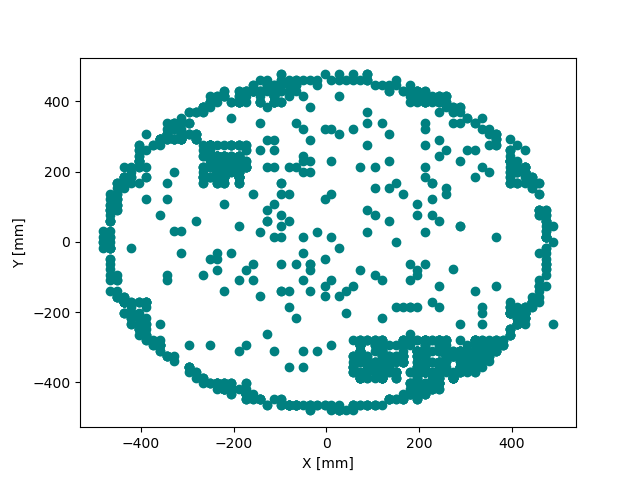

In [21]:
plt.figure()

low_E_S2 = data_properties_active_lt[data_properties_active_lt.S2_areaC < low_charge_lim]
# low_E_S2 = data_properties_active[data_properties_active.S2_area < low_charge_lim]

plt.scatter(low_E_S2.x, low_E_S2.y, color = "Teal")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")

# display(low_E_S2[low_E_S2.R < 200])


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_46290/2790404921.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


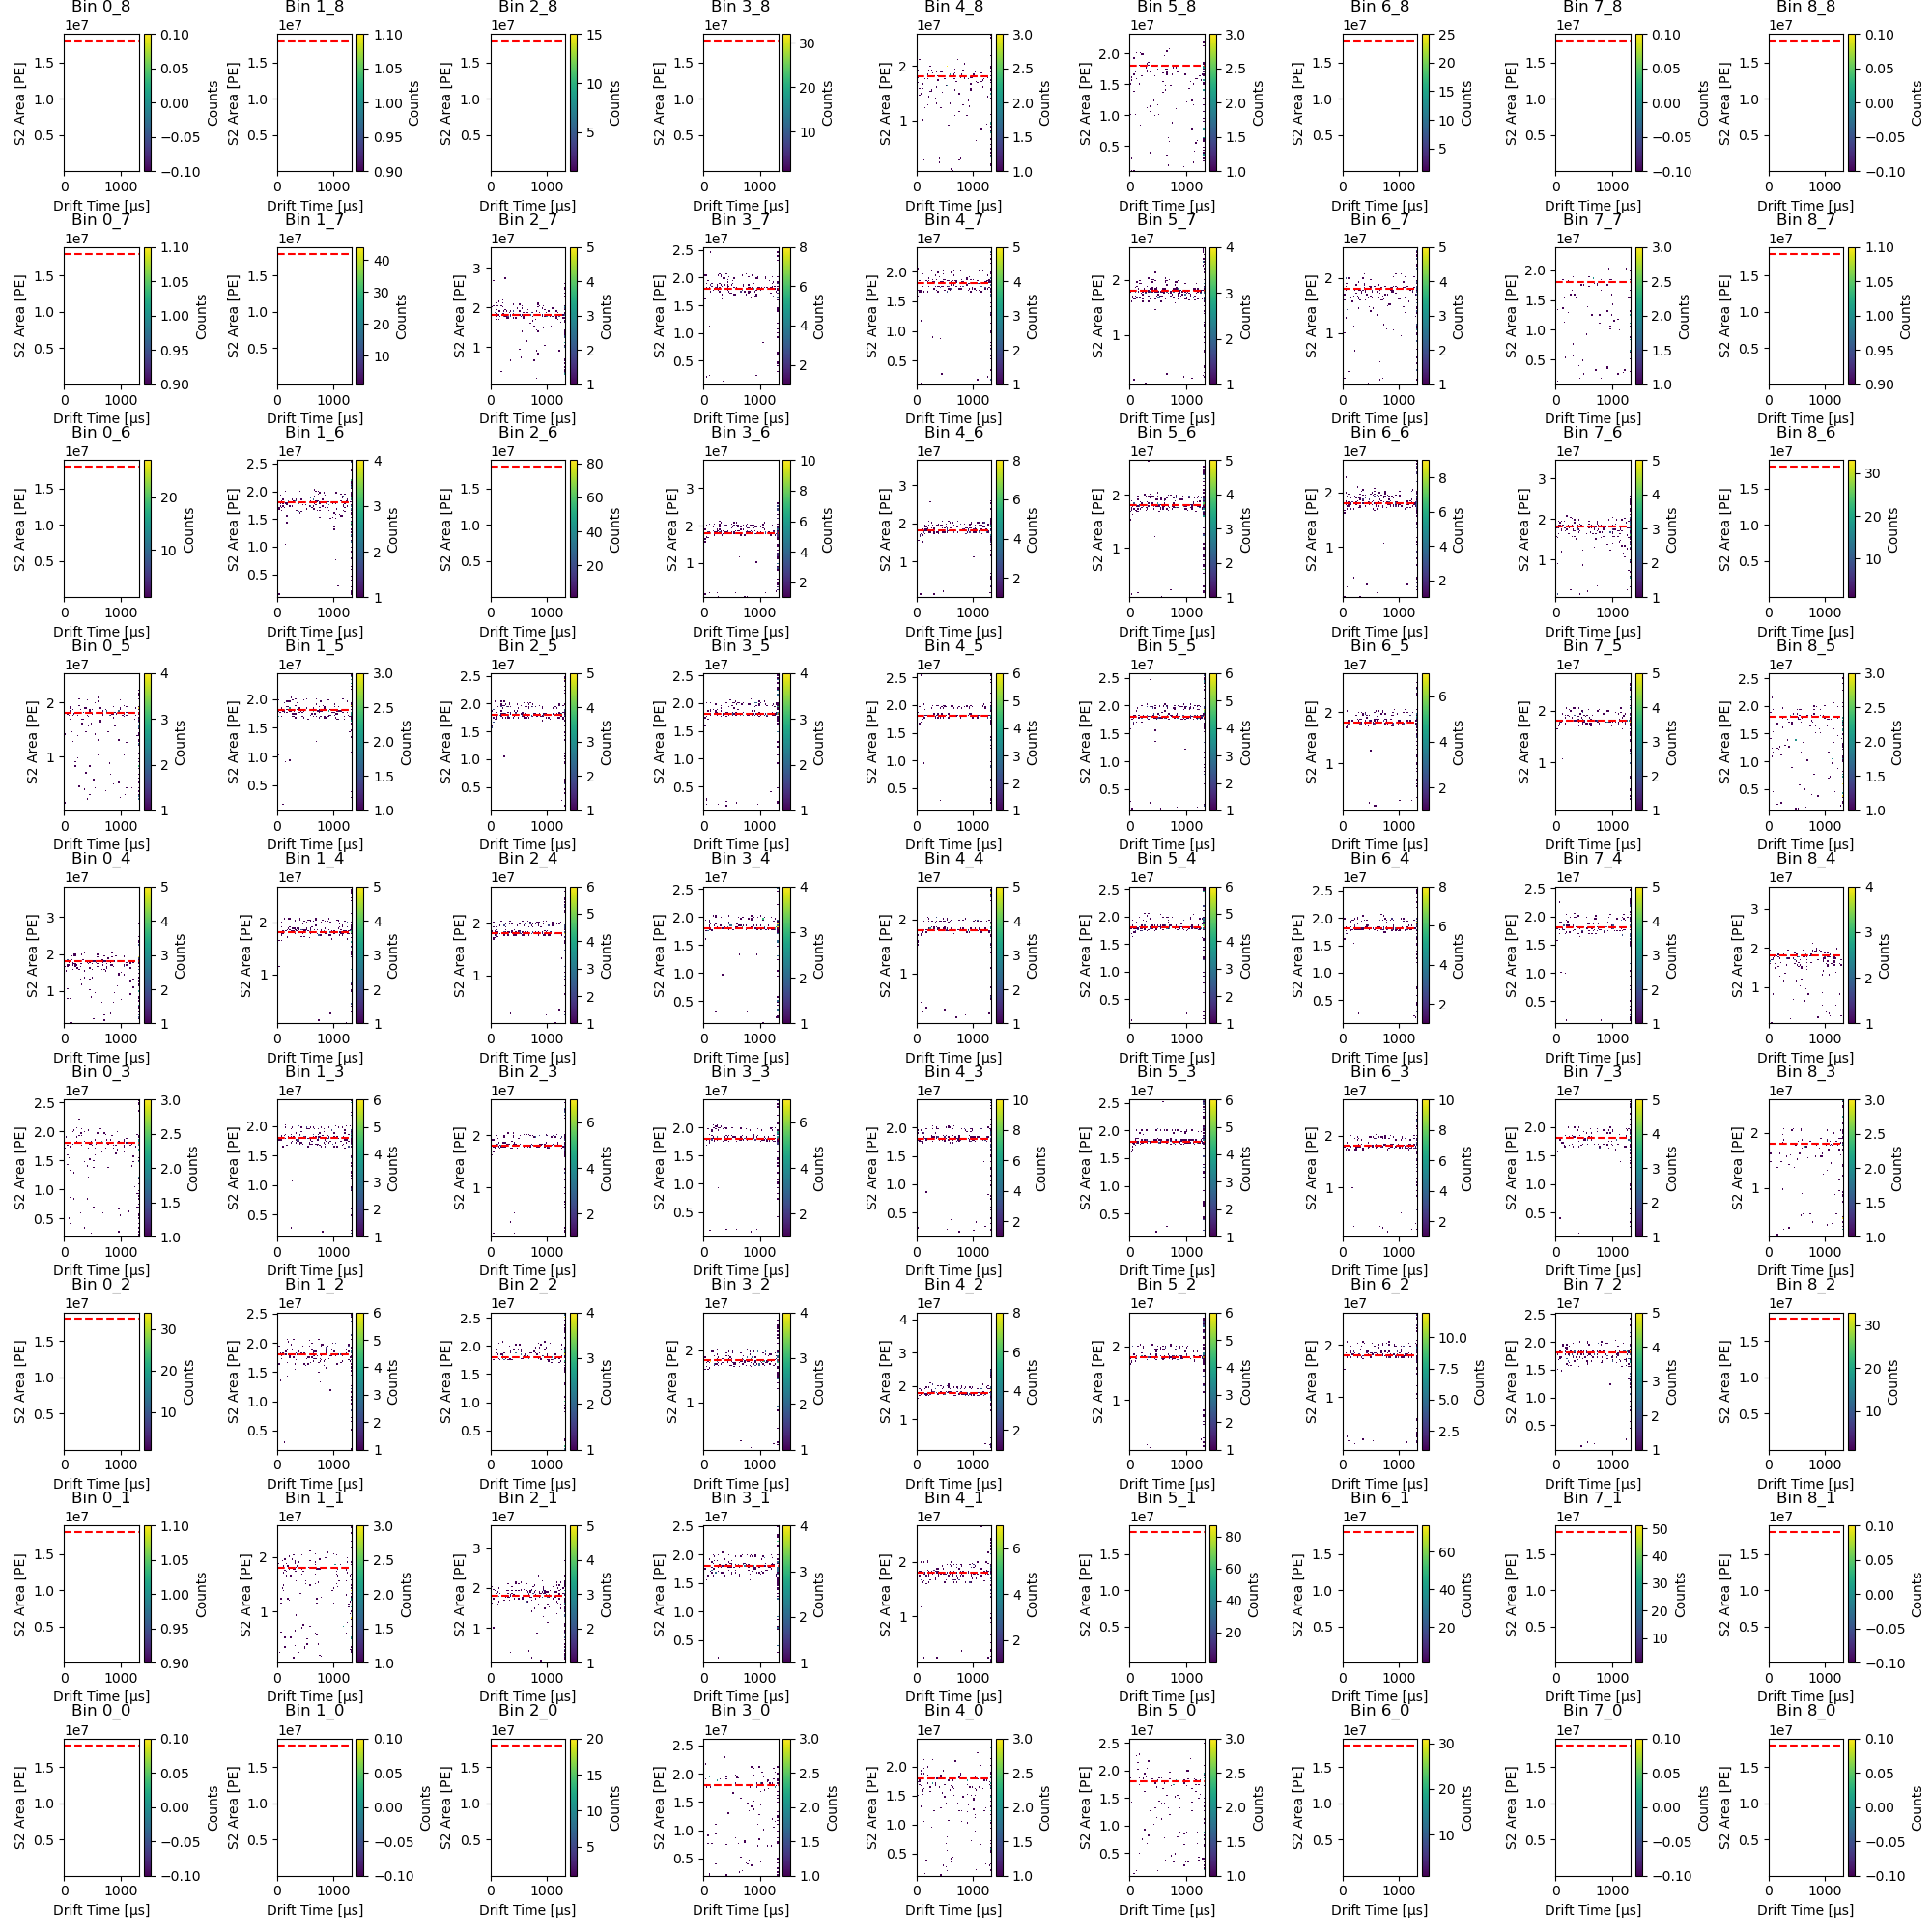

In [22]:
# Create a grid of subplots (5x5)
fig, axs = plt.subplots(nbins-1, nbins-1, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(nbins-2, -1, -1):
    for x in range(0, nbins-1, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_lt, "S2_areaC",f"{x}_{y}")   
        axs[counter].set_xlim(0,cathode_cut+50)
        axs[counter].axhline(y=q0_max, color='r', linestyle='--', linewidth=1.5)
        # axs[counter].set_ylim(2.5e8,5.5e8)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# Line
def Line(x, m, c):
    return m*x+c

17.837511775966014
PE conv factor =  3.139451326134709e-07


Text(24845105.687952664, 175, '7.7 MeV')

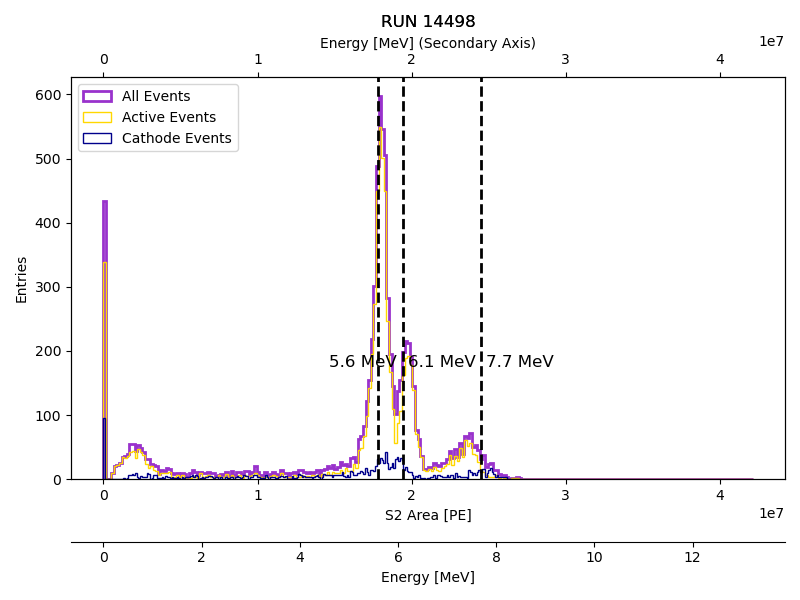

In [24]:
Radial_Cut = 350

# Histogram the S2 energy
fig, ax1 = plt.subplots(figsize = (8,6))

# data_properties_lt = data_properties_lt[ (data_properties_lt.S2_areaC < 6e7) & (data_properties_lt.S2_areaC > 1e7)]

ax1.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC, bins = 250, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
ax1.set_xlabel("S2 Area [PE]")
ax1.set_ylabel("Entries")

# plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
counts, xbins, _ = ax1.hist(data_properties_lt[(data_properties_lt.deltaT<cathode_cut) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 250, histtype = "step", label="Active Events", color="gold");
ax1.hist(data_properties_lt[(data_properties_lt.deltaT>cathode_cut) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 250, histtype = "step", label="Cathode Events", color="DarkBlue");
ax1.legend(loc="upper left")

bin_centers = (xbins[:-1] + xbins[1:]) / 2

max_bin_index = np.argmax(counts[1:])  # Index of the bin with the most counts
max_bin_value = xbins[max_bin_index]+0.015e7

print(max_bin_value/1e6)
PE_to_MeV = 5.6/max_bin_value
print("PE conv factor = ", PE_to_MeV)

ax1.set_title(f"RUN {RUN}")

# Create secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlabel("Energy [MeV] (Secondary Axis)")

# Set limits and fewer tick positions for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())


ax2 = ax1.secondary_xaxis("bottom", functions=(lambda x: x * PE_to_MeV, lambda x: x / PE_to_MeV))
ax2.set_xlabel("Energy [MeV]")
ax2.spines['bottom'].set_position(('outward', 45))

fig.tight_layout()

# plt.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
# plt.xlabel("S2 Area [MeV]")
# plt.ylabel("Entries")

# # plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
# counts, xbins, _ = plt.hist(data_properties_lt[(data_properties_lt.deltaT<794)& (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Active Events", color="gold");
# plt.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
# plt.legend(loc="upper left")

ax1.axvline(5.6/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(6.1/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(7.7/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
plt.title(f"RUN {RUN}")

ax1.text(4.6/PE_to_MeV, 175, '5.6 MeV', fontsize=12)
ax1.text(6.2/PE_to_MeV, 175, '6.1 MeV', fontsize=12)
ax1.text(7.8/PE_to_MeV, 175, '7.7 MeV', fontsize=12)


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R,cath_areaC
0,17351,7.075970e+05,7.317886e+05,1602.887048,36.162972,2524.901667,16.933063,1.730124e+09,-999.000,2.366650,...,333.333333,-222.222222,7_2,42208.920901,17491912.897136,333.333333,-222.222222,7.123448e+05,431.169000,35.478989
1,17358,9.804880e+06,9.791496e+06,1612.569223,370.746339,2531.626389,15.224785,1.730124e+09,-999.000,5.401290,...,-222.222222,-444.444444,2_0,0,0,-222.222222,-444.444444,0.000000e+00,458.547496,363.734074
4,17379,2.475571e+06,2.536587e+06,1606.024741,185.614031,2527.791667,15.768368,1.730124e+09,1322.300,6.234440,...,-111.111111,444.444444,3_8,0,0,-111.111111,444.444444,0.000000e+00,466.287456,190.365156
5,17386,1.423254e+07,1.428373e+07,1615.056949,447.775449,2510.681667,5.940399,1.730124e+09,1281.025,5.976276,...,333.333333,222.222222,7_6,60140.008604,16194140.304916,333.333333,222.222222,1.618810e+07,434.790871,458.874901
6,17393,1.810995e+07,1.843112e+07,1606.071545,291.569860,2528.879167,10.918723,1.730124e+09,95.625,2.258617,...,-222.222222,-222.222222,2_2,70833.518102,16742187.38516,-222.222222,-222.222222,1.953044e+07,324.152096,292.103277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,19369,1.757356e+07,1.725162e+07,1611.111311,428.097805,2523.941176,16.199269,1.730124e+09,655.850,4.591757,...,111.111111,0.000000,5_4,42251.287734,17932251.634297,111.111111,0.000000,1.794679e+07,105.167872,433.498234
15472,19376,1.633106e+07,1.685846e+07,1604.901445,122.552331,2517.045000,12.175788,1.730124e+09,67.325,1.689437,...,-222.222222,111.111111,2_5,37816.929231,17710668.245807,-222.222222,111.111111,1.665609e+07,276.400970,122.710140
15474,19390,1.223586e+07,1.223876e+07,1614.325710,475.245738,2519.226250,16.226891,1.730124e+09,1325.450,6.110655,...,333.333333,-111.111111,7_3,54735.208411,17562931.576247,333.333333,-111.111111,1.286989e+07,329.374432,487.439856
15475,19397,1.834463e+07,2.293836e+07,1604.155293,67.548117,2513.620000,11.334438,1.730124e+09,-999.000,1.925828,...,111.111111,111.111111,5_5,28279.93722,18007880.467929,111.111111,111.111111,1.773067e+07,142.712845,66.270518


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-0.6329371389520859 6.101372073114401


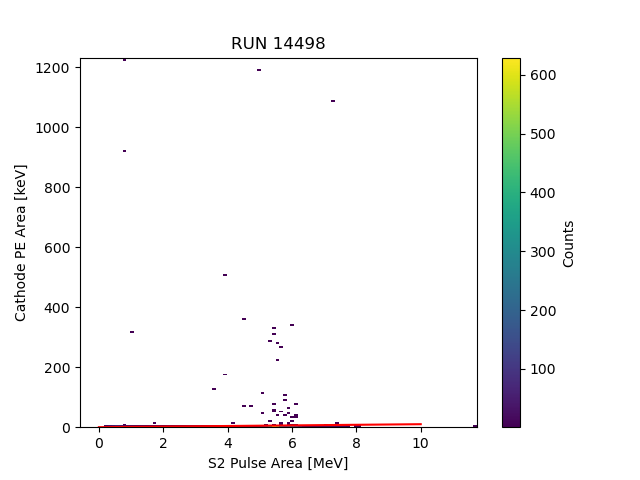

In [25]:
# 1. Create the 2D histogram

data_properties_lt = data_properties_lt[data_properties_lt.grass_peaks < 1]

display(data_properties_lt)

data_properties_lt['S2_area'] = data_properties_lt['S2_area'].fillna(0)
data_properties_lt['cath_area'] = data_properties_lt['cath_area'].fillna(0)

data_properties_lt_radial = data_properties_lt[data_properties_lt.R < 300]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties_lt_radial.S2_area*PE_to_MeV, data_properties_lt_radial.cath_area*PE_to_MeV*1000, bins=[100, 200])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")
# plt.ylim(0,2e6)
# plt.ylim(0,2e6*PE_to_MeV*1000)

plt.title(f"RUN {RUN}")

S2_arr = np.linspace(0,10, 100)

# Perform the curve fit
# params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bounds = ([1e8, 1e3], [4.5e8, 100e3]))
params, covariance = curve_fit(Line, data_properties_lt_radial.S2_area*PE_to_MeV, data_properties_lt_radial.cath_area*PE_to_MeV*1000)

# Extract the fitted parameters
m, c = params

print(m,c)

plt.plot(S2_arr, Line(S2_arr, 1, 0), c = "red")


In [26]:


data_properties_lt_copy = data_properties_lt.copy()

data_properties_lt_copy['S2_areaC'] = data_properties_lt_copy['S2_areaC']*PE_to_MeV
data_properties_lt_copy['cath_areaC'] = data_properties_lt_copy['cath_areaC']*PE_to_MeV
data_properties_lt_copy.to_hdf(f"../data/analysis/Properties_Run_{RUN}.h5", key='data_properties_lt', mode='w')


display(data_properties_lt_copy)

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_46290/3291657029.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['bin_id', 'lt', 'q0'], dtype='object')]

  data_properties_lt_copy.to_hdf(f"../data/analysis/Properties_Run_{RUN}.h5", key='data_properties_lt', mode='w')


,event,S2_area,S2_areafit,S2_time,cath_area,cath_time,cath_std,ts_raw,deltaT,sigma,...,x_bin_center,y_bin_center,bin_id,lt,q0,x_center,y_center,S2_areaC,R,cath_areaC
0,17351,7.075970e+05,7.317886e+05,1602.887048,36.162972,2524.901667,16.933063,1.730124e+09,-999.000,2.366650,...,333.333333,-222.222222,7_2,42208.920901,17491912.897136,333.333333,-222.222222,0.223637,431.169000,0.000011
1,17358,9.804880e+06,9.791496e+06,1612.569223,370.746339,2531.626389,15.224785,1.730124e+09,-999.000,5.401290,...,-222.222222,-444.444444,2_0,0,0,-222.222222,-444.444444,0.000000,458.547496,0.000114
4,17379,2.475571e+06,2.536587e+06,1606.024741,185.614031,2527.791667,15.768368,1.730124e+09,1322.300,6.234440,...,-111.111111,444.444444,3_8,0,0,-111.111111,444.444444,0.000000,466.287456,0.000060
5,17386,1.423254e+07,1.428373e+07,1615.056949,447.775449,2510.681667,5.940399,1.730124e+09,1281.025,5.976276,...,333.333333,222.222222,7_6,60140.008604,16194140.304916,333.333333,222.222222,5.082175,434.790871,0.000144
6,17393,1.810995e+07,1.843112e+07,1606.071545,291.569860,2528.879167,10.918723,1.730124e+09,95.625,2.258617,...,-222.222222,-222.222222,2_2,70833.518102,16742187.38516,-222.222222,-222.222222,6.131485,324.152096,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,19369,1.757356e+07,1.725162e+07,1611.111311,428.097805,2523.941176,16.199269,1.730124e+09,655.850,4.591757,...,111.111111,0.000000,5_4,42251.287734,17932251.634297,111.111111,0.000000,5.634307,105.167872,0.000136
15472,19376,1.633106e+07,1.685846e+07,1604.901445,122.552331,2517.045000,12.175788,1.730124e+09,67.325,1.689437,...,-222.222222,111.111111,2_5,37816.929231,17710668.245807,-222.222222,111.111111,5.229098,276.400970,0.000039
15474,19390,1.223586e+07,1.223876e+07,1614.325710,475.245738,2519.226250,16.226891,1.730124e+09,1325.450,6.110655,...,333.333333,-111.111111,7_3,54735.208411,17562931.576247,333.333333,-111.111111,4.040438,329.374432,0.000153
15475,19397,1.834463e+07,2.293836e+07,1604.155293,67.548117,2513.620000,11.334438,1.730124e+09,-999.000,1.925828,...,111.111111,111.111111,5_5,28279.93722,18007880.467929,111.111111,111.111111,5.566457,142.712845,0.000021
